This notebook provides examples to go along with the [textbook](http://manipulation.csail.mit.edu/robot.html).  I recommend having both windows open, side-by-side!

In [ ]:
"""
https://github.com/RobotLocomotion/drake/tree/master/
https://drake.mit.edu/pydrake/index.html
https://drake.mit.edu/doxygen_cxx/index.html

"""
# To do:
# Get Jacobain/impedance control working
# Fix mustad bottle contact / allow to float
# Make a variable x0 trajecotry to make contact
# Add actuation to gripper or bottle to simulate noise
# Open and close gripper


# Imports
import numpy as np
import pydot
import matplotlib.pyplot as plt
import os
from IPython.display import display, HTML, SVG
import pydrake.all
from pydrake.all import (
    AddMultibodyPlantSceneGraph, DiagramBuilder,
    FindResourceOrThrow, GenerateHtml, InverseDynamicsController, RollPitchYaw, RotationMatrix,
    MultibodyPlant, Parser, RigidTransform, Simulator, MeshcatVisualizerCpp, ModelInstanceInfo, LeafSystem,
    BasicVector, Adder, Demultiplexer, JacobianWrtVariable, ConstantVectorSource, SchunkWsgPositionController,
    PassThrough, MakeMultibodyStateToWsgStateSystem, Meshcat, SpatialInertia, UnitInertia, Box, CoulombFriction, AbstractValue,
    Quaternion, InputPortIndex)
import pydrake.geometry
from manipulation import running_as_notebook
from manipulation.utils import FindResource
from manipulation.meshcat_cpp_utils import (
  StartMeshcat, AddMeshcatTriad)#, MeshcatJointSlidersThatPublish)

In [ ]:
# Start the visualizer.
meshcat = StartMeshcat()
#meshcat2 = Meshcat()
#meshcat_animation = pydrake.all.MeshcatAnimation()
#meshcat.SetAnimation(meshcat_animation)

In [ ]:
#Two functions to help avoid Abstract Inputs/outputs so we can just use vector instead
def RT_to_Vector(X_AB):
    w = X_AB.rotation().ToQuaternion().w()
    x =  X_AB.rotation().ToQuaternion().x()
    y =  X_AB.rotation().ToQuaternion().y()
    z =  X_AB.rotation().ToQuaternion().z()
    return np.concatenate((np.array([w,x,y,z]),X_AB.translation()))

def Vector_to_RT(V):
    w1 = V[0]
    x1 = V[1]
    y1 = V[2]
    z1 = V[3]
    w = w1/np.sqrt(w1**2+x1**2+y1**2+z1**2)
    x = x1/np.sqrt(w1**2+x1**2+y1**2+z1**2)
    y = y1/np.sqrt(w1**2+x1**2+y1**2+z1**2)
    z = z1/np.sqrt(w1**2+x1**2+y1**2+z1**2)
    Q = Quaternion(w,x,y,z)
    R = RotationMatrix(Q)
    p = np.array([V[4],V[5],V[6]])
    return RigidTransform(R,p)


In [ ]:
#Iiwa Torque Controller class and Wsg Torque Controller Class (will be used as impedance controllers)
#REWRITE for: get passed x0, q0, th0M, Kx, Kq, etc.any
#Treating all rotation matrices as a quaternion vector (length of 4) so that I can 
#only use vector input ports and not abstract ports. because those suck.
#rigid transforms become np.concatenate((X.rotation().ToQuaternionAsVector4(), X.translation)) (I think this works? we shall find out)
class IiwaTorqueController(LeafSystem):
    def __init__(self, plant): #plant should only be controller_plant
        LeafSystem.__init__(self)
        self._plant = plant 
        self._plant_context = plant.CreateDefaultContext() 
        #self.Kx = Kx
        #self.Kq = Kq
        #self.Bx = Bx
        #self.Bq = Bq  

        self._iiwa = plant.GetModelInstanceByName("iiwa")
        self._G = plant.GetBodyByName("body").body_frame() 

        self._W = plant.world_frame()

        self.DeclareVectorInputPort("iiwa_state_measured", BasicVector(14))
        self.DeclareVectorInputPort("X_W0",BasicVector(7))
        self.DeclareVectorInputPort("Kx",BasicVector(3))
        self.DeclareVectorInputPort("Bx",BasicVector(3))
        self.DeclareVectorInputPort("Kth",BasicVector(3))
        self.DeclareVectorInputPort("Bth",BasicVector(3))
        self.DeclareVectorInputPort("q0",BasicVector(7))
        self.DeclareVectorInputPort("Kq",BasicVector(7))
        self.DeclareVectorInputPort("Bq",BasicVector(7))
        self.DeclareVectorInputPort("FF_torque",BasicVector(6))
        #T = AbstractValue.Make(RigidTransform)
        self.DeclareVectorOutputPort("iiwa_torque", BasicVector(7),
                                 self.CalcTorqueOutput)
    #def 
    def CalcTorqueOutput(self, context, output):
        state = self.get_input_port(0).Eval(context)
        X_W0 = Vector_to_RT(self.get_input_port(1).Eval(context))
        x0 = X_W0.translation()
        R_W0 = X_W0.rotation()

        #get impedance values
        Kx = np.diag(self.get_input_port(2).Eval(context))
        Bx = np.diag(self.get_input_port(3).Eval(context))
        Kth = np.diag(self.get_input_port(4).Eval(context))
        Bth = np.diag(self.get_input_port(5).Eval(context))

        q0 = self.get_input_port(6).Eval(context)
        Kq = np.diag(self.get_input_port(7).Eval(context))
        Bq = np.diag(self.get_input_port(8).Eval(context))
        ff = self.get_input_port(9).Eval(context)

        # Read inputs 
        q = state[0:7]
        q_dot = state[7:14]

        # Compute gripper position
        self._plant.SetPositions(self._plant_context, self._iiwa, q)
        X = self._plant.CalcRelativeTransform(self._plant_context, self._W, self._G)

        # Compute jacobian joint space to gripper
        J = self._plant.CalcJacobianSpatialVelocity(
            self._plant_context, JacobianWrtVariable.kQDot, 
            self._G, [0,0,0], self._W, self._W)
        #
        X_dot = np.matmul(J,q_dot)
        x0 = np.array([x0]).T #make into vertical vector
        x = np.array([X.translation()]).T
        x_dot = np.array([X_dot[3:6]]).T
        th_dot = np.array([X_dot[0:3]]).T

        #Rotation
        R_WG = X.rotation()
        R_GW = R_WG.transpose()
        R_G0 = R_GW.multiply(R_W0)
        R_0G = R_G0.transpose()
        aa = R_G0.ToAngleAxis()
        u0 = np.array([aa.axis()]).T
        deltaTh = aa.angle()

        #Jacobian 
        Jx = J[3:6,0:7] #bottom 3 because translational
        Jth = J[0:3,0:7] #

        #define separate torques
        tau_x = np.matmul(Jx.T,(np.matmul(Kx,x0-x) + np.matmul(Bx,-x_dot)))
        tau_q = np.matmul(Kq,(q0-q)) + np.matmul(Bq,(-q_dot))
        tau_th = np.matmul(Jth.T, np.matmul(Kth,np.matmul(R_0G.matrix() , u0*deltaTh)) + np.matmul(Bth,-th_dot) )

        
        # Add nullspace projector
        J_pseudo = np.matmul(J.T,np.linalg.inv(np.matmul(J,J.T)))
        N_tau = np.identity(7) - np.matmul(J.T,(J_pseudo.T))

        #add together and assign output
        a = tau_x + tau_th
        #print(tau_x.size)
        #print(tau_th.size)
        #print(a.shape)
        b = np.matmul(N_tau,tau_q)
        #print(b.shape)
        a = a.T[0]
        tau_ff = np.matmul(J.T,ff)
        tau_cmd =  a+b +tau_ff #used to find where matrix math goes wrong
        output.SetFromVector(tau_cmd)

class IiwaForwardKinematics(LeafSystem):
    def __init__(self, plant): #plant should only be controller_plant
        LeafSystem.__init__(self)
        self._plant = plant 
        self._plant_context = plant.CreateDefaultContext()  

        self._iiwa = plant.GetModelInstanceByName("iiwa")
        self._G = plant.GetBodyByName("body").body_frame() 

        self._W = plant.world_frame()
        self.DeclareVectorInputPort("iiwa_state", BasicVector(14))
        self.DeclareVectorOutputPort("X_WG",BasicVector(7),
                                self.ForwardKinematics)

    def ForwardKinematics(self,context,output):
        #return
        state = self.get_input_port(0).Eval(context)
        # Read inputs 
        q = state[0:7]
        q_dot = state[7:14]
        # Compute gripper position
        self._plant.SetPositions(self._plant_context, self._iiwa, q)
        X_WG = self._plant.CalcRelativeTransform(self._plant_context, self._W, self._G)
        out = RT_to_Vector(X_WG)
        output.SetFromVector(out)


class WsgTorqueController(LeafSystem):
    def __init__(self): #plant should only be controller_plant
        LeafSystem.__init__(self)

        self.DeclareVectorInputPort("wsg_position_measured", BasicVector(2))
        self.DeclareVectorInputPort("wsg_velocity_measured", BasicVector(2))
        self.DeclareVectorInputPort("closed", BasicVector(1)) #1 is closed, 0 is open
        self.DeclareVectorOutputPort("wsg_torque", BasicVector(2),
                                 self.CalcTorqueOutput)

    def CalcTorqueOutput(self, context, output):
        # Read inputs 

        x = self.get_input_port(0).Eval(context)
        xdot = self.get_input_port(1).Eval(context)
        closed = self.get_input_port(2).Eval(context)
        #x0 = self.get_input_port(2)
        K = 2000 #10000

        if closed==1:
            K=10000
            x0 = np.array([0,0]) #closed position
            amt = K*np.mean(x)
            f = 75
            t1 = f-amt
            t2 = -f-amt
            if t1<0:
                t2 = t2+t1
                t1 = 0
            if t2>0:
                t1 = t1+t2
                t2 = 0
            tau_cmd = np.array([t1,t2])


        else:
            K=2000
            x0 = np.array([-0.05,0.05]) #Open position
            tau_cmd = K*(x0 - x)

        output.SetFromVector(tau_cmd)

class StateMachine(LeafSystem):
    def __init__(self,ctrl_obj,plant):
        LeafSystem.__init__(self)
        self._ctrl_obj = ctrl_obj
        self._plant = plant
        self.DeclareVectorInputPort("iiwa1_state",BasicVector(14))
        self.DeclareVectorInputPort("iiwa2_state",BasicVector(14))
        self.DeclareVectorInputPort("iiwa1_X_WG",BasicVector(7))
        self.DeclareVectorInputPort("iiwa2_X_WG",BasicVector(7))
        self.DeclareVectorInputPort("wsg1_state",BasicVector(4))
        self.DeclareVectorInputPort("wsg2_state",BasicVector(4))
        self.DeclareVectorInputPort("drill_state",BasicVector(13))
        #self.DeclareVectorInputPort("time_for_change",BasicVector(1)) #becomes 1 if Duration exceeds 
        self.DeclareVectorOutputPort("Desired Positions and Impedances",BasicVector(94),self.Calc) #may need to change size, will need to demux
        #82 -> 94
    def Calc(self,context,output):
        #[x0,Kx,Bx,R_W0,Kth,Bth,q0,Kq,Bq]
        #iiwa1,iiwa2,wsg1,wsg2,taskDuration
        iiwa1_state = self.get_input_port(0).Eval(context)
        iiwa2_state = self.get_input_port(1).Eval(context)
        iiwa1_X_WG = Vector_to_RT(self.get_input_port(2).Eval(context))
        iiwa2_X_WG = Vector_to_RT(self.get_input_port(3).Eval(context))
        wsg1_state = self.get_input_port(4).Eval(context)
        wsg2_state = self.get_input_port(5).Eval(context)
        drill_state = self.get_input_port(6).Eval(context)

        iiwa1, iiwa2, wsg1, wsg2, iiwa1_ff, iiwa2_ff = self._ctrl_obj.stateMachine(iiwa1_state,iiwa2_state,
        iiwa1_X_WG,iiwa2_X_WG,wsg1_state,wsg2_state,drill_state,context.get_time(),context,self._plant) 
        wsg1 = np.array([wsg1])
        wsg2 = np.array([wsg2])

        iiwa1_vec = np.concatenate((RT_to_Vector(RigidTransform(iiwa1[3],iiwa1[0])),iiwa1[1],iiwa1[2],iiwa1[4],iiwa1[5],iiwa1[6],iiwa1[7],iiwa1[8]))
        iiwa2_vec = np.concatenate((RT_to_Vector(RigidTransform(iiwa2[3],iiwa2[0])),iiwa2[1],iiwa2[2],iiwa2[4],iiwa2[5],iiwa2[6],iiwa2[7],iiwa2[8]))
        
        out = np.concatenate((iiwa1_vec,iiwa2_vec,wsg1,wsg2,iiwa1_ff,iiwa2_ff))
        
        output.SetFromVector(out)

class Timer(LeafSystem):
    def __init__(self):
        LeafSystem.__init__(self)
        self.DeclareVectorInputPort("taskDuration",BasicVector(1))
        self.DeclareVectorOutputPort("time_for_change",BasicVector(1),self.CheckForChange)
        self.start_time = 0

    def CheckForChange(self,context,output):
        t0 = self.start_time
        D = self.get_input_port(0).Eval(context) 

        t = context.get_time()
        if t>=(t0+D):
            output.SetFromVector(1) #its been long enough, tell state machine it is time for a change
            self.start_time = t #update start time (assuming you are starting new task)
        else:
            output.SetFromVector(0)

In [ ]:
#Helper functions for following functions
def AddIiwa(plant, iiwa_name="iiwa", collision_model="no_collision", p_iiwa = np.array([0,0,0])):
    X_iiwa = RigidTransform(p_iiwa)
    sdf_path = pydrake.common.FindResourceOrThrow(
        "drake/manipulation/models/iiwa_description/sdf/iiwa14_polytope_collision.sdf")

    parser = pydrake.multibody.parsing.Parser(plant)
    iiwa = parser.AddModelFromFile(sdf_path,iiwa_name)
    plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("iiwa_link_0",iiwa),X_iiwa)

    # Set default positions:
    q0 = [0.0, 0.1, 0, -1.2, 0, 1.6, 0]
    index = 0
    for joint_index in plant.GetJointIndices(iiwa):
        joint = plant.get_mutable_joint(joint_index)
        if isinstance(joint, pydrake.multibody.tree.RevoluteJoint):
            joint.set_default_angle(q0[index])
            index += 1

    return iiwa

def AddWsg(plant, iiwa_model_instance, gripper_name="gripper", roll=np.pi / 2.0, welded=False):
    parser = pydrake.multibody.parsing.Parser(plant)
    if welded:
        parser.package_map().Add(
            "wsg_50_description",
            os.path.dirname(
                pydrake.common.FindResourceOrThrow(
                    "drake/manipulation/models/wsg_50_description/package.xml"))
        )
        gripper = parser.AddModelFromFile(
            FindResource("models/schunk_wsg_50_welded_fingers.sdf"), "gripper")
    else:
        gripper = parser.AddModelFromFile(
            pydrake.common.FindResourceOrThrow(
                "drake/manipulation/models/"
                "wsg_50_description/sdf/schunk_wsg_50_no_tip.sdf"),gripper_name)

    X_7G = RigidTransform(RollPitchYaw(np.pi / 2.0, 0, roll), [0, 0, 0.114])
    plant.WeldFrames(plant.GetFrameByName("iiwa_link_7", iiwa_model_instance),
                     plant.GetFrameByName("body", gripper), X_7G)
    return gripper

def AddDrill(plant):
    parser = pydrake.multibody.parsing.Parser(plant)
    drill = parser.AddModelFromFile("./035_power_drill/drill3.sdf")
    return drill

def AddTestDrill(plant):
    parser = pydrake.multibody.parsing.Parser(plant)
    drill = parser.AddModelFromFile("./035_power_drill/test.sdf")
    return drill

def AddFloor(plant):
    mu = 1
    floor = plant.AddModelInstance("floor")
    floor_body = plant.AddRigidBody("floor_body",floor,SpatialInertia(
                                     mass = 0.2, 
                                     p_PScm_E=np.array([0., 0., 0.]),
                                     G_SP_E = UnitInertia(1.0, 1.0, 1.0)))
    shape = Box(3,3,.05)
    if plant.geometry_source_is_registered():
        plant.RegisterCollisionGeometry(floor_body, RigidTransform(), shape, "floor_body", CoulombFriction(mu, mu))
        plant.RegisterVisualGeometry(floor_body, RigidTransform(), shape, "floor_body", [.9, .2, .2, 1.0])
    plant.WeldFrames(plant.world_frame(),floor_body.body_frame(),X_PC = RigidTransform(RotationMatrix(),np.array([0,0,-.05/2]))) #center it so top is at z=0
    return floor

def AddBox(plant):
    mu = 1
    box = plant.AddModelInstance("box")
    box_body = plant.AddRigidBody("box_body",box,SpatialInertia(
                                     mass = 0.2, 
                                     p_PScm_E=np.array([0., 0., 0.]),
                                     G_SP_E = UnitInertia(1.0, 1.0, 1.0)))
    shape = Box(0.12,0.12,0.05)
    if plant.geometry_source_is_registered():
        plant.RegisterCollisionGeometry(box_body, RigidTransform(), shape, "box_body", CoulombFriction(mu, mu))
        plant.RegisterVisualGeometry(box_body, RigidTransform(), shape, "box_body", [.15, .15, .15, 1.0])
    plant.WeldFrames(plant.world_frame(),box_body.body_frame(),X_PC = RigidTransform(RotationMatrix(),np.array([0.5,0.,0.05/2]))) #center it so bottom is at z=0
    return box

def SetupIiwa (builder, plant, iiwa, iiwa_name, num_iiwa_positions,time_step,p_iiwa=np.array([0,0,0])):
    """
    Setup iiwa with gravity compensation and a possible input torque (will be impedance control)
    iiwa_name is string like 'iiwa1'
    iiwa is reference to iiwa1 or iiwa2

    assigns to the builder: iiwa_name+"_torque" as an input (set to 0 by default)
    """
    #iiwa_position = builder.AddSystem(PassThrough(num_iiwa_positions))
    #builder.ExportInput(iiwa_position.get_input_port(), iiwa_name+"_position")
    #builder.ExportOutput(iiwa_position.get_output_port(), iiwa_name+"_position_command")
    
    # Export the iiwa "state" outputs.
    #demux = builder.AddSystem(Demultiplexer(
        #2 * num_iiwa_positions, num_iiwa_positions))
    #builder.Connect(plant.get_state_output_port(iiwa), demux.get_input_port())

    # Make the plant for the iiwa controller to use.
    controller_plant = MultibodyPlant(time_step=time_step)
    controller_iiwa = AddIiwa(controller_plant,p_iiwa=p_iiwa)
    AddWsg(controller_plant, controller_iiwa, welded=True)
    controller_plant.Finalize()

    # Add the iiwa controller
    iiwa_controller = builder.AddSystem(
        InverseDynamicsController(
            controller_plant,
            kp=[0]*num_iiwa_positions,
            ki=[0]*num_iiwa_positions,
            kd=[0]*num_iiwa_positions,
            has_reference_acceleration=False))
    iiwa_controller.set_name(iiwa_name+"_InverseDynamics_controller")

    #set desired and estimated state to be equal, and gains to 0 so that position control doesn't happen
    builder.Connect(
        plant.get_state_output_port(iiwa), iiwa_controller.get_input_port_estimated_state())
    
    builder.Connect(plant.get_state_output_port(iiwa), iiwa_controller.get_input_port_desired_state()) 

    # Add in the feed-forward torque
    adder = builder.AddSystem(Adder(2, num_iiwa_positions))
    builder.Connect(iiwa_controller.get_output_port_control(),
                    adder.get_input_port(0))
    builder.Connect(adder.get_output_port(),
                    plant.get_actuation_input_port(iiwa))

    iiwa_torque_controller = builder.AddSystem(IiwaTorqueController(controller_plant)) #create torque controller
    iiwa_torque_controller.set_name(iiwa_name+"_torque_controller")
    builder.Connect(iiwa_torque_controller.get_output_port(0),adder.get_input_port(1)) #connect output to feedforward part of adder
    builder.Connect(plant.get_state_output_port(iiwa),iiwa_torque_controller.get_input_port(0))
    
    iiwa_fk = SetupIiwaFK(builder,iiwa_name,time_step,p_iiwa)
    builder.Connect(plant.get_state_output_port(iiwa),iiwa_fk.get_input_port(0))
    
    return iiwa_torque_controller,iiwa_fk

def SetupIiwaFK(builder,iiwa_name,time_step,p_iiwa):
    '''
    Sets up iiwa forward kinematices calculator, useful for looking at X coords not just q in external controllers
    Possible to set this up without adding a sepearate leafSystem, but I couldn't figure out dependency ticket stuff and 
    I was getting algebraic loop errors
    '''
    controller_plant = MultibodyPlant(time_step=time_step)
    controller_iiwa = AddIiwa(controller_plant,p_iiwa=p_iiwa)
    AddWsg(controller_plant, controller_iiwa, welded=True)
    controller_plant.Finalize()
    iiwa_fk = builder.AddSystem(IiwaForwardKinematics(controller_plant))
    iiwa_fk.set_name(iiwa_name+"_forward_kinematics")
    return iiwa_fk

    

def SetupWsg(builder,plant,wsg,wsg_name):
    """
    adds wsg controller. 
    TODO: Need to change because because it is currently position controlled. 
    Want to have it impedance congtrolled instead I think
    """
    # Wsg controller.


    wsg_controller = builder.AddSystem(WsgTorqueController())
    wsg_controller.set_name(wsg_name+"_controller")
    builder.Connect(
            wsg_controller.get_output_port(),             
            plant.get_actuation_input_port(wsg))
    demux = builder.AddSystem(Demultiplexer(4,2))
    #demux.name = wsg_name + "_state_demux"
    builder.Connect(plant.get_state_output_port(wsg),
                    demux.get_input_port())
    builder.Connect(demux.get_output_port(0),wsg_controller.get_input_port(0))
    builder.Connect(demux.get_output_port(1),wsg_controller.get_input_port(1))
    return wsg_controller

def SetupStateMachine(builder,plant,ctrl_fun,iiwa1,iiwa1_ctrl,iiwa2,iiwa2_ctrl,wsg1,wsg1_ctrl,wsg2,wsg2_ctrl,drill,iiwa1_fk,iiwa2_fk):
    #[x0,Kx,Bx,R_W0,Kth,Bth,q0,Kq,Bq] [x0,Kx,Bx,R_W0,Kth,Bth,q0,Kq,Bq]
    state_machine = builder.AddSystem(StateMachine(ctrl_fun,plant))
    demux = builder.AddSystem(Demultiplexer([7,3,3,3,3,7,7,7,7,3,3,3,3,7,7,7,1,1,6,6])) #see state machine for reasoning 
    builder.Connect(state_machine.get_output_port(),demux.get_input_port())

    #connect state machine inputs to iiwa states and wsg states
    builder.Connect(plant.get_state_output_port(iiwa1),state_machine.get_input_port(0))
    builder.Connect(plant.get_state_output_port(iiwa2),state_machine.get_input_port(1))

    builder.Connect(iiwa1_fk.get_output_port(0),state_machine.get_input_port(2))
    builder.Connect(iiwa2_fk.get_output_port(0),state_machine.get_input_port(3))

    builder.Connect(plant.get_state_output_port(wsg1),state_machine.get_input_port(4))
    builder.Connect(plant.get_state_output_port(wsg2),state_machine.get_input_port(5))

    builder.Connect(plant.get_state_output_port(drill),state_machine.get_input_port(6))

    #Demux properly?
    #X_W0,Kx,Bx,Kth,Bth,q0,Kq,Bq
    #then iiwa2, etc.
    builder.Connect(demux.get_output_port(0),iiwa1_ctrl.get_input_port(1))
    builder.Connect(demux.get_output_port(1),iiwa1_ctrl.get_input_port(2))
    builder.Connect(demux.get_output_port(2),iiwa1_ctrl.get_input_port(3))
    builder.Connect(demux.get_output_port(3),iiwa1_ctrl.get_input_port(4))
    builder.Connect(demux.get_output_port(4),iiwa1_ctrl.get_input_port(5))
    builder.Connect(demux.get_output_port(5),iiwa1_ctrl.get_input_port(6))
    builder.Connect(demux.get_output_port(6),iiwa1_ctrl.get_input_port(7))
    builder.Connect(demux.get_output_port(7),iiwa1_ctrl.get_input_port(8))

    #iiwa2 now
    builder.Connect(demux.get_output_port(8),iiwa2_ctrl.get_input_port(1))
    builder.Connect(demux.get_output_port(9),iiwa2_ctrl.get_input_port(2))
    builder.Connect(demux.get_output_port(10),iiwa2_ctrl.get_input_port(3))
    builder.Connect(demux.get_output_port(11),iiwa2_ctrl.get_input_port(4))
    builder.Connect(demux.get_output_port(12),iiwa2_ctrl.get_input_port(5))
    builder.Connect(demux.get_output_port(13),iiwa2_ctrl.get_input_port(6))
    builder.Connect(demux.get_output_port(14),iiwa2_ctrl.get_input_port(7))
    builder.Connect(demux.get_output_port(15),iiwa2_ctrl.get_input_port(8))

    #wsgs
    builder.Connect(demux.get_output_port(16),wsg1_ctrl.get_input_port(2))
    builder.Connect(demux.get_output_port(17),wsg2_ctrl.get_input_port(2))
    
    builder.Connect(demux.get_output_port(18),iiwa1_ctrl.get_input_port(9))
    builder.Connect(demux.get_output_port(19),iiwa2_ctrl.get_input_port(9))


In [ ]:
#Nic is trying out some things from manipulationstation python code russ uploaded on piazza
#Pass as many control functions as you want. wsg control is not implemented right now though
def MakeManipulationTask(meshcat,ctrl_fun,test=False,time_step=0.002):
    builder = DiagramBuilder()
    # Add the two iiwas, WSGs, (and drill? not yet) to the scene.
    plant, scene_graph = AddMultibodyPlantSceneGraph(
        builder, time_step=time_step)

    p_iiwa2 = np.array([1,0,0])
    
    iiwa1 = AddIiwa(plant,iiwa_name="iiwa1",collision_model="polytope_collision") #collision_model doesn't actually set the collision model. check AddIiwa code for that
    iiwa2 = AddIiwa(plant,iiwa_name="iiwa2",collision_model="polytope_collision",p_iiwa=p_iiwa2)
    wsg1 = AddWsg(plant,iiwa1,gripper_name="wsg1")
    wsg2 = AddWsg(plant,iiwa2,gripper_name="wsg2")
    #Parser(plant).AddModelFromFile(
        #FindResource("models/camera_box.sdf"), "camera0")
    drill = AddDrill(plant) #
    floor = AddFloor(plant)
    box = AddBox(plant)
    #test = AddTestDrill(plant) #only for testing
    #plant.WeldFrames(plant.GetFrameByName("mesh_drill"),plant.GetFrameByName("base_test")) #only for testing
    plant.Finalize()

    num_iiwa_positions = plant.num_positions(iiwa1)

    iiwa1_ctrl,iiwa1_fk = SetupIiwa(builder,plant,iiwa1,"iiwa1",num_iiwa_positions,time_step)
    iiwa2_ctrl,iiwa2_fk = SetupIiwa(builder,plant,iiwa2,"iiwa2",num_iiwa_positions,time_step,p_iiwa=p_iiwa2)

    wsg1_ctrl = SetupWsg(builder,plant,wsg1,"wsg1")
    wsg2_ctrl = SetupWsg(builder,plant,wsg2,"wsg2")

    SetupStateMachine(builder,plant,ctrl_fun,iiwa1,iiwa1_ctrl,iiwa2,iiwa2_ctrl,wsg1,wsg1_ctrl,wsg2,wsg2_ctrl,drill,iiwa1_fk,iiwa2_fk)

    visualizer = MeshcatVisualizerCpp.AddToBuilder(builder,scene_graph.get_query_output_port(),meshcat)

    #diagram = builder.Build()
    instances = [iiwa1,iiwa2,wsg1,wsg2,drill,floor,box]

    return plant, builder, visualizer, instances

def TestDrillGeometry(meshcat,time_step=0.002):
    builder=DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(
        builder, time_step=time_step)
    drill = AddDrill(plant)
    test = AddTestDrill(plant)
    floor = AddFloor(plant)
    #box = AddBox(plant)
    plant.WeldFrames(plant.GetFrameByName("mesh_drill"),plant.GetFrameByName("base_test"),RigidTransform(RotationMatrix(),np.array([0.2,0,0]))) #only for testing

    plant.Finalize()
    visualizer = MeshcatVisualizerCpp.AddToBuilder(builder,scene_graph.get_query_output_port(),meshcat)
    diagram = builder.Build()

    R = RotationMatrix.MakeXRotation(np.pi/2)
    R = R.ToQuaternion()
    q_drill = np.zeros(7)
    q_drill[0] = R.w()
    q_drill[1] = R.x()
    q_drill[2] = R.y()
    q_drill[3] = R.z()
    q_drill[4] = 0 #x pos of drill to start
    q_drill[5] = 0 #y pos of drill to start
    q_drill[6] = 0.115 #z pos of drill to start


    context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyMutableContextFromRoot(context)
    plant.SetPositions(plant_context,drill,q_drill)
    
    simulator = Simulator(diagram, context)
    visualizer.StartRecording()
    simulator.AdvanceTo(1)
    visualizer.PublishRecording()

    return
#WSG controllers have inputs (time, x, xdot)
#Iiwa controllers have inputs (time, x, q, qdot, J)


In [ ]:
def getMinJerkTraj_1D(D,A,tstart,tt):
  if tt <= tstart:
    x = 0.0
    v = 0.0
    a = 0.0
  elif tt > tstart+D:
    t = D
    x = A*( (10/D**3)*t**3 + (-15/D**4)*t**4 + (6/D**5)*t**5 )
    v = 0
    a = 0
  else:
    t = tt-tstart
    x = A*( (10/D**3)*t**3 + (-15/D**4)*t**4 +  (6/D**5)*t**5 )
    v = A*( (30/D**3)*t**2 + (-60/D**4)*t**3 +  (30/D**5)*t**4 )
    a = A*( (60/D**3)*t   + (-180/D**4)*t**2 + (120/D**5)*t**3 )
  return x,v,a

def getMinJerkTraj(D,deltaX,tstart,tt):

  x,tmp1,tmp2 = getMinJerkTraj_1D(D,deltaX[0],tstart,tt)
  y,tmp1,tmp2 = getMinJerkTraj_1D(D,deltaX[1],tstart,tt)
  z,tmp1,tmp2 = getMinJerkTraj_1D(D,deltaX[2],tstart,tt)

  X = np.array([x, y, z])

  return X

# # Test Min Jerk Trajectory
# N = 3000
# D = 1.
# A = 1.
# tStart = 0.5
# ttRange = np.linspace(0., 3., N)

# # Initialize variables
# x = np.zeros(N)
# v = np.zeros(N)
# a = np.zeros(N)

# for i in range(N):
#     x[i],v[i],a[i] = getMinJerkTraj_1D(D,A,tStart,ttRange[i])
# fig, ax = plt.subplots(3)

# ax[0].plot(ttRange, x)
# ax[1].plot(ttRange, v)
# ax[2].plot(ttRange, a)

# t = np.linspace(0., 2, 500)
# x = np.sin(2*np.pi*30*t)
# plt.plot(t,x)
# plt.show()

In [ ]:
# State Machine 
"""
States diagram and notes: 
0 - State: start: [X_iiwa1 == X_iiwa1Start], [X_iiwa2 == X_iiwa2Start], [X_drill == X_drillStart]
    Action: pickDrill() start --> drillPick

1 - State: drillPicked: [X_iiwa1 == X_iiwa1DrillStart], [X_iiwa2 == X_iiwa2Start], [X_drill == iiwa1Grasp]
    Action: move2PrePush(): drillPicked --> holdDrillPrePush1Hand
    
2 - State: holdDrillPrePush1Hand: [X_iiwa1 == X_iiwa1PrePush], [X_iiwa2 == X_iiwa2Start], [X_drill == iiwa1Grasp]
    Action: pushOnDrill1Hand(): holdDrillPrePush1Hand --> pushingOnDrill1Hand [oneHandTask == True]
    Action:  graspDrillIiwa2(): holdDrillPrePush1Hand --> holdDrillPrePush2Hand [oneHandTask == False]
        This method may eventually use anti-podal grasp approach

3 - State: pushingOnDrill1Hand: [X_iiwa1 == X_iiwa1Push], [X_iiwa2 == X_iiwa2Start], [X_drill == iiwa1Grasp]

4 - State: pushingOnDrill2Hand: [X_iiwa1 == X_iiwa1Push], [X_iiwa2 == X_iiwa2Push], [X_drill == iiwa1Iiwa2Grasp]

5 - State: Problem: 
    Action: Terminate simulation


States and Action diagram notes: 
0 - State: start: [X_iiwa1 == X_iiwa1Start], [X_iiwa2 == X_iiwa2Start], [X_drill == X_drillStart]
1 - State: drillPicked: [X_iiwa1 == X_iiwa1DrillStart], [X_iiwa2 == X_iiwa2Start], [X_drill == iiwa1Grasp]
2 - State: holdDrillPrePush1Hand: [X_iiwa1 == X_iiwa1PrePush], [X_iiwa2 == X_iiwa2Start], [X_drill == iiwa1Grasp]
3 - State: pushingOnDrill1Hand: [X_iiwa1 == X_iiwa1Push], [X_iiwa2 == X_iiwa2Start], [X_drill == iiwa1Grasp]
4 - State: pushingOnDrill2Hand: [X_iiwa1 == X_iiwa1Push], [X_iiwa2 == X_iiwa2Push], [X_drill == iiwa1Iiwa2Grasp]
5 - State: Problem: 

0 - Action: pickDrill() start --> drillPick
1 - Action: move2PrePush(): drillPicked --> holdDrillPrePush1Hand
2 - Action: pushOnDrill1Hand(): holdDrillPrePush1Hand --> pushingOnDrill1Hand [oneHandTask == True]
3 - Action:  graspDrillIiwa2(): holdDrillPrePush1Hand --> holdDrillPrePush2Hand [oneHandTask == False]
        This method may eventually use anti-podal grasp approach
4 - Action: Terminate simulation
"""
def atPosition(x1,x2,delta):
    if (np.linalg.norm(x1 - x2)/3) < delta:
        return True
    else:
        return False


def get_initialPos(oneArmTask):

    # q_iiwa1 = np.array([[-np.pi/2,np.pi/2,np.pi/2,-np.pi/2,0.,np.pi/2,np.pi/2]]).T
    q_iiwa1 = np.array([[0.,0.,0.,0.,0.,0.,0.]]).T

    if not oneArmTask:
        q_iiwa2 = np.array([[np.pi/2,np.pi/2,np.pi/2,-np.pi/2,0.,np.pi/2,np.pi/2]]).T
    else:
        q_iiwa2 = np.array([[0.,0.,0.,0.,0.,0.,0.]]).T

    #R = RotationMatrix().MakeZRotation(np.pi/2).MakeXRotation(np.pi/2).ToQuaternion() #sets the drill upright
    R1 = RotationMatrix().MakeYRotation(0.)#-np.pi/2)
    R = R1.multiply(RotationMatrix().MakeZRotation(-np.pi/2))
    R = RotationMatrix.MakeXRotation(np.pi/2)
    R = R.ToQuaternion()
    q_drill = np.zeros(7)
    q_drill[0] = R.w()
    q_drill[1] = R.x()
    q_drill[2] = R.y()
    q_drill[3] = R.z()
    q_drill[4] = 0.3 #0.6 #x pos of drill to start
    q_drill[5] = -0.2 #y pos of drill to start
    q_drill[6] = 0.1 #z pos of drill to start

    return q_iiwa1, q_iiwa2, q_drill

class SM():
    def __init__(self,meshcat):
        self.oneArmTask = True
        self.meshcat = meshcat
        self.currentAction = 0
        self.taskDuration = 0
        self.taskStartTime = 0
        self.drillTipLength = 0.078
        self.boxHeight = 0.05

        self.drill_state = []
        self.init_q_iiwa1, self.init_q_iiwa2, self.init_q_drill = get_initialPos(self.oneArmTask)

        self.X_iiwa1Start = []
        self.X_iiwa2Start = []
        self.X_drillStart = self.init_q_drill[4:7]
        self.X_iiwa1DrillStart = self.X_drillStart + np.array([0.01, -0.2, 0.02])
        self.X_iiwa1Grasp =      self.X_drillStart + np.array([0, -0.09, 0.02])
        self.X_iiwa1PrePush = np.array([0.55, -0.1, 0.2+self.boxHeight])
        self.X_iiwa1Push = np.array([0.55, -0.1, self.drillTipLength+self.boxHeight])
        self.X_iiwa2Push = np.array([0.55, -0.1, self.drillTipLength+self.boxHeight])
        self.prev_iiwa1_X_WG = self.init_q_iiwa1
        self.prev_iiwa2_X_WG = self.init_q_iiwa2
        self.initial = True
        self.X_iiwa2Grasp_iiwa2PreGrasp = RigidTransform(RotationMatrix(),np.array([0,0,-.2]))
        self.X_D_iiwa2Grasp = RigidTransform(RotationMatrix(),np.array([0.,-0.1,-0.1]))

    
    def stateMachine(self,iiwa1_state,iiwa2_state,iiwa1_X_WG, iiwa2_X_WG,wsg1_state,wsg2_state,drill_state,t,context,plant):
        self.X_WD = Vector_to_RT(drill_state[0:7])
        '''
        if t==int(t):
            name = str(t)
            AddMeshcatTriad(self.meshcat, "painter/" + name,
                        length=.15, radius=.006, X_PT=self.X_WD)'''
        if self.initial:
            self.X_iiwa1Start = iiwa1_X_WG.translation()
            self.X_iiwa2Start = iiwa2_X_WG.translation()
            print(self.X_iiwa1Start)
            self.initial = False


        self.drill_state = drill_state


        if self.currentAction == 0:
            iiwa1,iiwa2,wsg1,wsg2,iiwa1_ff,iiwa2_ff = self.pickDrill(iiwa1_X_WG,iiwa2_X_WG,t)
        
        elif self.currentAction == 1:
            iiwa1,iiwa2,wsg1,wsg2,iiwa1_ff,iiwa2_ff = self.move2PrePush(iiwa1_X_WG,iiwa2_X_WG,t)
            iiwa1_ff[0] = self.get_x_torque_comp(plant,[iiwa1_state,iiwa2_state,wsg1_state,wsg2_state,drill_state])
        
        elif self.currentAction == 2:
            iiwa1,iiwa2,wsg1,wsg2,iiwa1_ff,iiwa2_ff = self.pushOnDrill1Hand(iiwa1_X_WG,iiwa2_X_WG,t)
            iiwa1_ff[0] = self.get_x_torque_comp(plant,[iiwa1_state,iiwa2_state,wsg1_state,wsg2_state,drill_state])

        elif self.currentAction == 3:
            iiwa1,iiwa2,wsg1,wsg2,iiwa1_ff,iiwa2_ff = self.graspDrillIiwa2(iiwa1_X_WG,iiwa2_X_WG,t)
            iiwa1_ff[0] = self.get_x_torque_comp(plant,[iiwa1_state,iiwa2_state,wsg1_state,wsg2_state,drill_state])

        elif self.currentAction == 4:
            iiwa1,iiwa2,wsg1,wsg2,iiwa1_ff,iiwa2_ff = self. pushOnDrill2Hand(iiwa1_X_WG,iiwa2_X_WG,t)
            iiwa1_ff[0] = self.get_x_torque_comp(plant,[iiwa1_state,iiwa2_state,wsg1_state,wsg2_state,drill_state])

        else:
        # Terminate Simulation
            print("Learn how to terminate simulation.")
        
        self.stateTransition(iiwa1_X_WG, iiwa2_X_WG, t)
        
        iiwa1_ff = np.array([0,0,0,0,0,0])

        return iiwa1,iiwa2,wsg1,wsg2,iiwa1_ff,iiwa2_ff

    def stateTransition(self, iiwa1_X_WG, iiwa2_X_WG, t):
        """
        stateTransition
        Checks time to determine the Action should be completed
        Checks state to see if action was successful
        If so it updates currentState
        """
        prev_iiwa1_X_WG = self.prev_iiwa1_X_WG
        prev_iiwa2_X_WG = self.prev_iiwa2_X_WG

        drill_pos = self.drill_state[4:7]
        if t == (self.taskStartTime + self.taskDuration):
            print("Action Complete:",self.currentAction," Time:", t)

            delta = 0.2
            if  self.currentAction == 0: 
                # Check is State: drillPicked was reached
                if (  atPosition(iiwa1_X_WG.translation(),self.X_iiwa1DrillStart,delta) 
                    & atPosition(iiwa2_X_WG.translation(),self.X_iiwa2Start,delta) 
                    & atPosition(iiwa1_X_WG.translation(),drill_pos,delta)):
                    self.currentAction = 1

                else:
                    # Terminate Simulation
                    print("Learn how to terminate simulation.")
            
            elif  self.currentAction == 1: 
            # Check is State: holdDrillPrePush1Hand was reached
                if (  atPosition(iiwa1_X_WG.translation(),self.X_iiwa1PrePush,delta) 
                    & atPosition(iiwa2_X_WG.translation(),self.X_iiwa2Start,delta) 
                    & atPosition(iiwa1_X_WG.translation(),drill_pos,delta)):
                    if(self.oneArmTask):
                        self.currentAction = 2
                    else:
                        self.currentAction = 3
                else:
                    # Terminate Simulation
                    print("Learn how to terminate simulation.")

            elif  self.currentAction == 2: 
            # Check is State: holdDrillPush1Hand was reached
                if (  atPosition(iiwa1_X_WG.translation(),self.X_iiwa1Push,delta) 
                    & atPosition(iiwa2_X_WG.translation(),self.X_iiwa2Start,delta) 
                    & atPosition(iiwa1_X_WG.translation(),drill_pos,delta)):
                    self.currentAction = 0
                else:
                    # Terminate Simulation
                    print("Learn how to terminate simulation.")

            elif  self.currentAction == 3: 
            # Check is State: holdDrillPrePush2Hand was reached
                if (  atPosition(iiwa1_X_WG.translation(),self.X_iiwa1PrePush,delta)  
                    & atPosition(iiwa1_X_WG.translation(),drill_pos,delta)):
                    self.currentAction = 4
                else:
                    # Terminate Simulation
                    print("Learn how to terminate simulation.")

            elif  self.currentAction == 4: 
            # Check is State: holdDrillPush2Hand was reached
                if (  atPosition(iiwa1_X_WG.translation(),self.X_iiwa1Push,delta) 
                    & atPosition(iiwa2_X_WG.translation(),self.X_iiwa2Push,delta) 
                    & atPosition(iiwa1_X_WG.translation(),drill_pos,delta)):
                    self.currentAction = 0
                else:
                    # Terminate Simulation
                    print("Learn how to terminate simulation.")
            else:
                # Terminate Simulation
                print("Learn how to terminate simulation.")

            # Update class object
            self.taskStartTime = t
            self.prev_iiwa1_X_WG = iiwa1_X_WG
            self.prev_iiwa2_X_WG = iiwa2_X_WG     
      
    #############################################################################        
    # Task functions

    def pickDrill(self,iiwa1_X_WG,iiwa2_X_WG,t):
        # Temporary hard code a constant X0 and q0
        # ** Need to figure add cordinate transforms here

        """
        Other inputs needed:
        tStart: time that the functionw as called (do controla after that realtive?)
        X_drill: Can we get this from systemState?
        xStart:
        """

        # IIWA 1 ###############################################################

        ########################
        ## Gripper Translation##
        ########################

        # Define Submovement Durations
        D_M1 = 2
        D_pause = 1
        D_M2 = 2
        D_grasp = 2

        self.taskDuration = D_M1 + D_pause + D_M2 + D_grasp


        # Pregrasp Submovement
        tStart_M1 = self.taskStartTime
        deltaX = self.X_iiwa1DrillStart - self.X_iiwa1Start
        deltaX0_1 = getMinJerkTraj(D_M1,deltaX,tStart_M1,t)

        # Grasp Submovment
        tStart_M2 = tStart_M1 + D_M1 + D_pause
        deltaX = self.X_iiwa1Grasp - self.X_iiwa1DrillStart 
        deltaX0_2 = getMinJerkTraj(D_M2,deltaX,tStart_M2,t)

        x0 = self.X_iiwa1Start + deltaX0_1 + deltaX0_2
        
        # Impedance
        Kx = np.array([2500., 2500., 2500.])
        Bx = 0.2*Kx

        ######################
        ## Gripper Rotation ##
        ######################

        # Compute theta displacements using axis angle representation to 0 refrence frame
        tStart = self.taskStartTime
        A = 0. # -(1/2)*np.pi
        th0,tmp1,tmp2 = getMinJerkTraj_1D(D_M1,A,tStart,t)

        R_W0 = RotationMatrix().MakeYRotation(th0)
        Kth = np.array([50.,50., 50.])
        Bth = 0.2*Kth

        ###################
        ## Joint Rotation##
        ###################

        # q0 = np.array([0.,0.,0.,0.,0.,0.,0.])
        q0 = self.init_q_iiwa1.flatten()

        # Define join space stiffness
        Kq = np.array([10., 10., 10., 10., 10., 10., 10.])
        Bq = 0.2*Kq

        # wsg1 ###############################################################
        if (t - self.taskStartTime) < (self.taskDuration - D_grasp):
            wsg1 = 0
        else:
            wsg1 = 1

        ## Format Output #################################
        iiwa1 = wrapParams(x0,Kx,Bx,R_W0,Kth,Bth,q0,Kq,Bq)
        iiwa2 = wrapParams(x0,0*Kx,Bx,R_W0,0*Kth,Bth,self.init_q_iiwa2.flatten(),Kq,Bq)
        wsg2 = 0
        #print("x0",x0)
        #print("Kx",Kx)
        #print("Bx",Bx)
        #print("R_W0",R_W0)
        #print("Kth",Kth)
        #print("Bth",Bth)
        #print("q0",q0)
        #print("Kq",Kq)
        #print("Bq",Bq)

        # # IIWA 2 ###############################################################

        # ########################
        # ## Gripper Translation##
        # ########################

        # x0 = self.X_iiwa2Start
        
        # # Impedance
        # Kx = np.array([2500., 2500., 2500.])
        # Bx = 0.2*Kx

        # ######################
        # ## Gripper Rotation ##
        # ######################

        # # Compute theta displacements using axis angle representation to 0 refrence frame
        # tStart = self.taskStartTime
        # A = -(1/3)*np.pi
        # th0,tmp1,tmp2 = getMinJerkTraj_1D(D_M1,A,tStart,t)

        # R_W0 = RotationMatrix().MakeYRotation(0.)
        # Kth = np.array([50.,50., 50.])
        # Bth = 0.2*Kth

        # ###################
        # ## Joint Rotation##
        # ###################

        # # q0 = np.array([0.,0.,0.,0.,0.,0.,0.])
        # q0 = self.init_q_iiwa1.flatten()

        # # Define join space stiffness
        # Kq = np.array([10., 10., 10., 10., 10., 10., 10.])
        # Bq = 0.2*Kq

        # ## Format Output #################################
        # iiwa2 = wrapParams(x0,Kx,Bx,R_W0,Kth,Bth,self.init_q_iiwa2.flatten(),Kq,Bq)
        iiwa1_ff = np.array([0,0,0,0,0,0])
        iiwa2_ff = np.array([0,0,0,0,0,0])
        return iiwa1,iiwa2,wsg1,wsg2,iiwa1_ff,iiwa2_ff


    def move2PrePush(self,iiwa1_X_WG,iiwa2_X_WG,t):

        # IIWA 1 ###############################################################

        ########################
        ## Gripper Translation##
        ########################

        # Define Submovement Durations
        D_M1 = 2
        D_R1 = 5
        D_pause = 2

        self.taskDuration = D_M1 + D_R1 + D_pause

        # Submovement
        tStart_M1 = self.taskStartTime
        deltaX = self.X_iiwa1PrePush - self.X_iiwa1Grasp
        deltaX0_1 = getMinJerkTraj(D_M1,deltaX,tStart_M1,t)

        x0 = self.X_iiwa1Grasp + deltaX0_1
        
        # Impedance
        Kx = np.array([5000., 5000., 5000.])
        Bx = 0.2*Kx

        ######################
        ## Gripper Rotation ##
        ######################

        # Compute theta displacements using axis angle representation to 0 refrence frame
        tStart_R1 = self.taskStartTime + D_M1
        A = -(1/2)*np.pi
        th0,tmp1,tmp2 = getMinJerkTraj_1D(D_R1,A,tStart_R1,t)

        R_W0 = RotationMatrix().MakeYRotation(th0)
        Kth = np.array([100., 100., 10.])
        Bth = 0.3*np.array([100., 100., 100.])#Kth

        ###################
        ## Joint Rotation##
        ###################
        q0 = self.init_q_iiwa1.flatten()

        # Define join space stiffness
        Kq = np.array([10., 10., 10., 10., 10., 10., 10.])
        Bq = 0.2*Kq

        ## Format Output #################################
        iiwa1 = wrapParams(x0,Kx,Bx,R_W0,Kth,Bth,q0,Kq,Bq)
        iiwa2 = wrapParams(x0,0*Kx,Bx,R_W0,0*Kth,Bth,self.init_q_iiwa2.flatten(),Kq,Bq)
        wsg1 = 1
        wsg2 = 0
        iiwa1_ff = np.array([0,0,0,0,0,3.2*9.81])
        iiwa2_ff = np.array([0,0,0,0,0,0])
        return iiwa1,iiwa2,wsg1,wsg2,iiwa1_ff,iiwa2_ff


    def pushOnDrill1Hand(self,iiwa1_X_WG,iiwa2_X_WG,t):

        x0,Kx,Bx,R_W0,Kth,Bth,q0,Kq,Bq,iiwa1_ff = self.wrapper_iiwa1DrillPush(iiwa1_X_WG,iiwa2_X_WG,t)

        ## Format Output #################################
        iiwa1 = wrapParams(x0,Kx,Bx,R_W0,Kth,Bth,q0,Kq,Bq)
        iiwa2 = wrapParams(x0,0*Kx,Bx,R_W0,0*Kth,Bth,self.init_q_iiwa2.flatten(),Kq,Bq)
        wsg1 = 1
        wsg2 = 1
        # 10*np.sin(2*np.pi*3*t)
        #iiwa1_ff = np.array([0,0,0,0,0,3.2*9.81])
        iiwa2_ff = np.array([0,0,0,0,0,0])
        
        return iiwa1,iiwa2,wsg1,wsg2,iiwa1_ff,iiwa2_ff


    def graspDrillIiwa2(self,iiwa1_X_WG,iiwa2_X_WG,t):

        # Temporary hard code a constant X0 and q0
        # ** Need to figure add cordinate transforms here

        """
        Other inputs needed:
        tStart: time that the functionw as called (do controla after that realtive?)
        X_drill: Can we get this from systemState?
        xStart:
        """

        # IIWA 1 ###############################################################

        ########################
        ## Gripper Translation##
        ########################

        x0 = self.X_iiwa1PrePush
        
        # Impedance
        Kx = np.array([5000., 5000., 5000.])
        Bx = 0.2*Kx

        ######################
        ## Gripper Rotation ##
        ######################

        # Compute theta displacements using axis angle representation to 0 refrence frame
        th0 = -(1/2)*np.pi

        R_W0 = RotationMatrix().MakeYRotation(th0)
        Kth = np.array([50., 100., 10.])
        Bth = 0.3*np.array([500., 500., 500.])

        ###################
        ## Joint Rotation##
        ###################

        q0 = self.init_q_iiwa1.flatten()

        # Define join space stiffness
        Kq = np.array([10., 10., 10., 10., 10., 10., 10.])
        Bq = 0.2*Kq

        iiwa1 = wrapParams(x0,Kx,Bx,R_W0,Kth,Bth,q0,Kq,Bq)

        # IIWA 2 ###############################################################

        ########################
        ## Gripper Translation##
        ########################

        # Define Submovement Durations
        D_M1 = 2
        D_pause = 1
        D_M2 = 2
        D_grasp = 2

        self.taskDuration = D_M1 + D_pause + D_M2 + D_grasp

        X_W_iiwa2Grasp = self.X_WD @ self.X_D_iiwa2Grasp
        X_W_iiwa2PreGrasp = X_W_iiwa2Grasp @ self.X_iiwa2Grasp_iiwa2PreGrasp
        # Pregrasp Submovement
        tStart_M1 = self.taskStartTime
        deltaX = X_W_iiwa2PreGrasp.translation() - self.X_iiwa2Start
        deltaX0_1 = getMinJerkTraj(D_M1,deltaX,tStart_M1,t)

        # Grasp Submovment
        tStart_M2 = tStart_M1 + D_M1 + D_pause
        deltaX = X_W_iiwa2Grasp.translation() - X_W_iiwa2PreGrasp.translation()
        deltaX0_2 = getMinJerkTraj(D_M2,deltaX,tStart_M2,t)

        x0 = self.X_iiwa2Start + deltaX0_1 + deltaX0_2
        self.X_iiwa2PrePush = X_W_iiwa2Grasp.translation()
        # Impedance
        Kx = np.array([2500., 2500., 2500.])
        Bx = 0.2*Kx

        ######################
        ## Gripper Rotation ##
        ######################

        # Compute theta displacements using axis angle representation to 0 refrence frame
        tStart = self.taskStartTime
        A = np.pi/2
        th0,tmp1,tmp2 = getMinJerkTraj_1D(D_M2+D_pause,A,tStart,t)

        R_W0 = RotationMatrix().MakeZRotation(np.pi).MakeYRotation(np.pi)
        Kth = np.array([100., 100., 10.])
        Bth = 0.2*np.array([100., 100., 100.])

        ###################
        ## Joint Rotation##
        ###################

        q0 = self.init_q_iiwa2.flatten()

        # Define join space stiffness
        Kq = np.array([20., 20., 20., 20., 20., 20., 20.])
        Bq = 0.2*Kq

        # wsg2 ###############################################################
        if (t - self.taskStartTime) < (self.taskDuration - D_grasp):
            wsg2 = 0
        else:
            wsg2 = 1

        ## Format Output #################################
        iiwa2 = wrapParams(x0,Kx,Bx,R_W0,Kth,Bth,q0,Kq,Bq)
        wsg1 = 1
   
        iiwa1_ff = np.array([0,0,0,0,0,3.2*9.81])
        iiwa2_ff = np.array([0,0,0,0,0,0])
        return iiwa1,iiwa2,wsg1,wsg2,iiwa1_ff,iiwa2_ff

    def pushOnDrill2Hand(self,iiwa1_X_WG,iiwa2_X_WG,t):
       
       # IIWA 1 ###############################################################

        x0,Kx,Bx,R_W0,Kth,Bth,q0,Kq,Bq,iiwa1_ff = self.wrapper_iiwa1DrillPush(iiwa1_X_WG,iiwa2_X_WG,t)

        iiwa1 = wrapParams(x0,Kx,Bx,R_W0,Kth,Bth,q0,Kq,Bq)

        # IIWA 2 ###############################################################

        ########################
        ## Gripper Translation##
        ########################
 
        #X_D_pre = RigidTransform
        #X_W_iiwa2PrePush = self.X_WD.multiply(self.X_D_iiwa2PrePush)

        # Pregrasp Submovement
        tStart_M1 = self.taskStartTime
        #deltaX = self.X_iiwa2Push - X_W_iiwa2PrePush.translation()
        #deltaX0_1 = getMinJerkTraj(D_M1,deltaX,tStart_M1,t)

        x0 = self.X_iiwa2PrePush #+ deltaX0_1
        
        # Impedance
        Kx = np.array([1000., 1000., 0.])
        Bx = 0.2*np.array([1000., 1000., 1000.])

        ######################
        ## Gripper Rotation ##
        ######################

        R_W0 = RotationMatrix().MakeZRotation(np.pi).MakeYRotation(np.pi)
        Kth = np.array([100., 100., 10.])
        Bth = 0.3*Kth

        ###################
        ## Joint Rotation##
        ###################

        q0 = self.init_q_iiwa1.flatten()

        # Define joint space stiffness
        Kq = np.array([10., 10., 10., 10., 10., 10., 10.])
        Bq = 0.2*Kq

        ## Format Output #################################
        iiwa2 = wrapParams(x0,0*Kx,Bx,R_W0,0*Kth,Bth,self.init_q_iiwa2.flatten(),Kq,Bq)
        wsg1 = 1
        wsg2 = 1
        #iiwa1_ff = np.array([0,0,0,0,0,3.2*9.81])
        iiwa2_ff = np.array([0,0,0,0,0,0])

        return iiwa1,iiwa2,wsg1,wsg2,iiwa1_ff,iiwa2_ff

    def get_x_torque_comp(self,plant,states):
        wsg1 = plant.GetModelInstanceByName("wsg1")
        wsg2 = plant.GetModelInstanceByName("wsg2")
        iiwa2 = plant.GetModelInstanceByName("iiwa2")
        iiwa1 = plant.GetModelInstanceByName("iiwa1")
        drill = plant.GetModelInstanceByName("drill")

        G = plant.GetBodyByName("body",wsg1).body_frame()
        D = plant.GetBodyByName("mesh_drill").body_frame() 
        context = plant.CreateDefaultContext()
        plant.SetPositions(context,iiwa1,states[0][0:7])
        plant.SetPositions(context,wsg1,states[2][0:2])
        plant.SetPositions(context,drill,states[4][0:7])
        X_GD = plant.CalcRelativeTransform(context, G, D)
        M_drill = 3.2
        g = 9.81
        p = X_GD.translation()
        d = np.sqrt(p[0]**2+p[1]**2)
        return d*M_drill*g

    def wrapper_iiwa1DrillPush(self,iiwa1_X_WG,iiwa2_X_WG,t):
        # Temporary hard code a constant X0 and q0
        # ** Need to figure add cordinate transforms here

        """
        Other inputs needed:
        tStart: time that the functionw as called (do controla after that realtive?)
        X_drill: Can we get this from systemState?
        xStart:
        """

        # IIWA 1 ###############################################################

        ########################
        ## Gripper Translation##
        ########################

        # Define Submovement Durations
        D_M1 = 5
        D_hold = 5

        self.taskDuration = D_M1 + D_hold

        # Pregrasp Submovement
        tStart_M1 = self.taskStartTime
        deltaX = self.X_iiwa1Push - self.X_iiwa1PrePush
        deltaX0_1 = getMinJerkTraj(D_M1,deltaX,tStart_M1,t)

        x0 = self.X_iiwa1PrePush + deltaX0_1
        
        # Impedance
        Kx = np.array([1000., 1000., 1000.])
        Bx = 0.2*Kx

        ######################
        ## Gripper Rotation ##
        ######################

        # Compute theta displacements using axis angle representation to 0 refrence frame
        tStart = self.taskStartTime + D_M1
        A = 0. # -(1/2)*np.pi
        # th0,tmp1,tmp2 = getMinJerkTraj_1D(D_M1,A,tStart_M1,t)
        th0 = -(1/2)*np.pi

        R_W0 = RotationMatrix().MakeYRotation(th0)
        Kth = np.array([100., 100., 10.])
        Bth = 0.3*np.array([100., 100., 100.])#Kth

        ###################
        ## Joint Rotation##
        ###################

        q0 = self.init_q_iiwa1.flatten()

        # Define joint space stiffness
        Kq = np.array([20., 20., 20., 20., 20., 20., 20.])
        Bq = 0.2*Kq

        iiwa1_ff = np.array([0,0,0,0,0,3.2*9.81])
        if (t - self.taskStartTime) > (D_M1):
            iiwa1_ff = np.array([0,0,0,0,0,-3.2*9.81])
        if (t-self.taskStartTime) > (D_M1+D_hold):
            iiwa1_ff = np.array([0,0,0,0,0,3.2*9.81])
            
        return x0,Kx,Bx,R_W0,Kth,Bth,q0,Kq,Bq,iiwa1_ff
    


In [ ]:

def wrapParams(x0,Kx,Bx,R_W0,Kth,Bth,q0,Kq,Bq):
    params = [x0,Kx,Bx,R_W0,Kth,Bth,q0,Kq,Bq]
    return params

def  unwrapParams(params):
    x0 = params[0]
    Kx = params[1]
    Bx = params[2]
    R_W0 = params[3]
    Kth = params[4]
    Bth = params[5]
    q0 = params[6]
    Kq = params[7]
    Bq = params[8]
    # return x0,Kx,Bx,R_W0,Kth,Bth,q0,Kq,Bq
    return np.concatenate((x0,Kx,Bx,R_W0,Kth,Bth,q0,Kq,Bq)) 

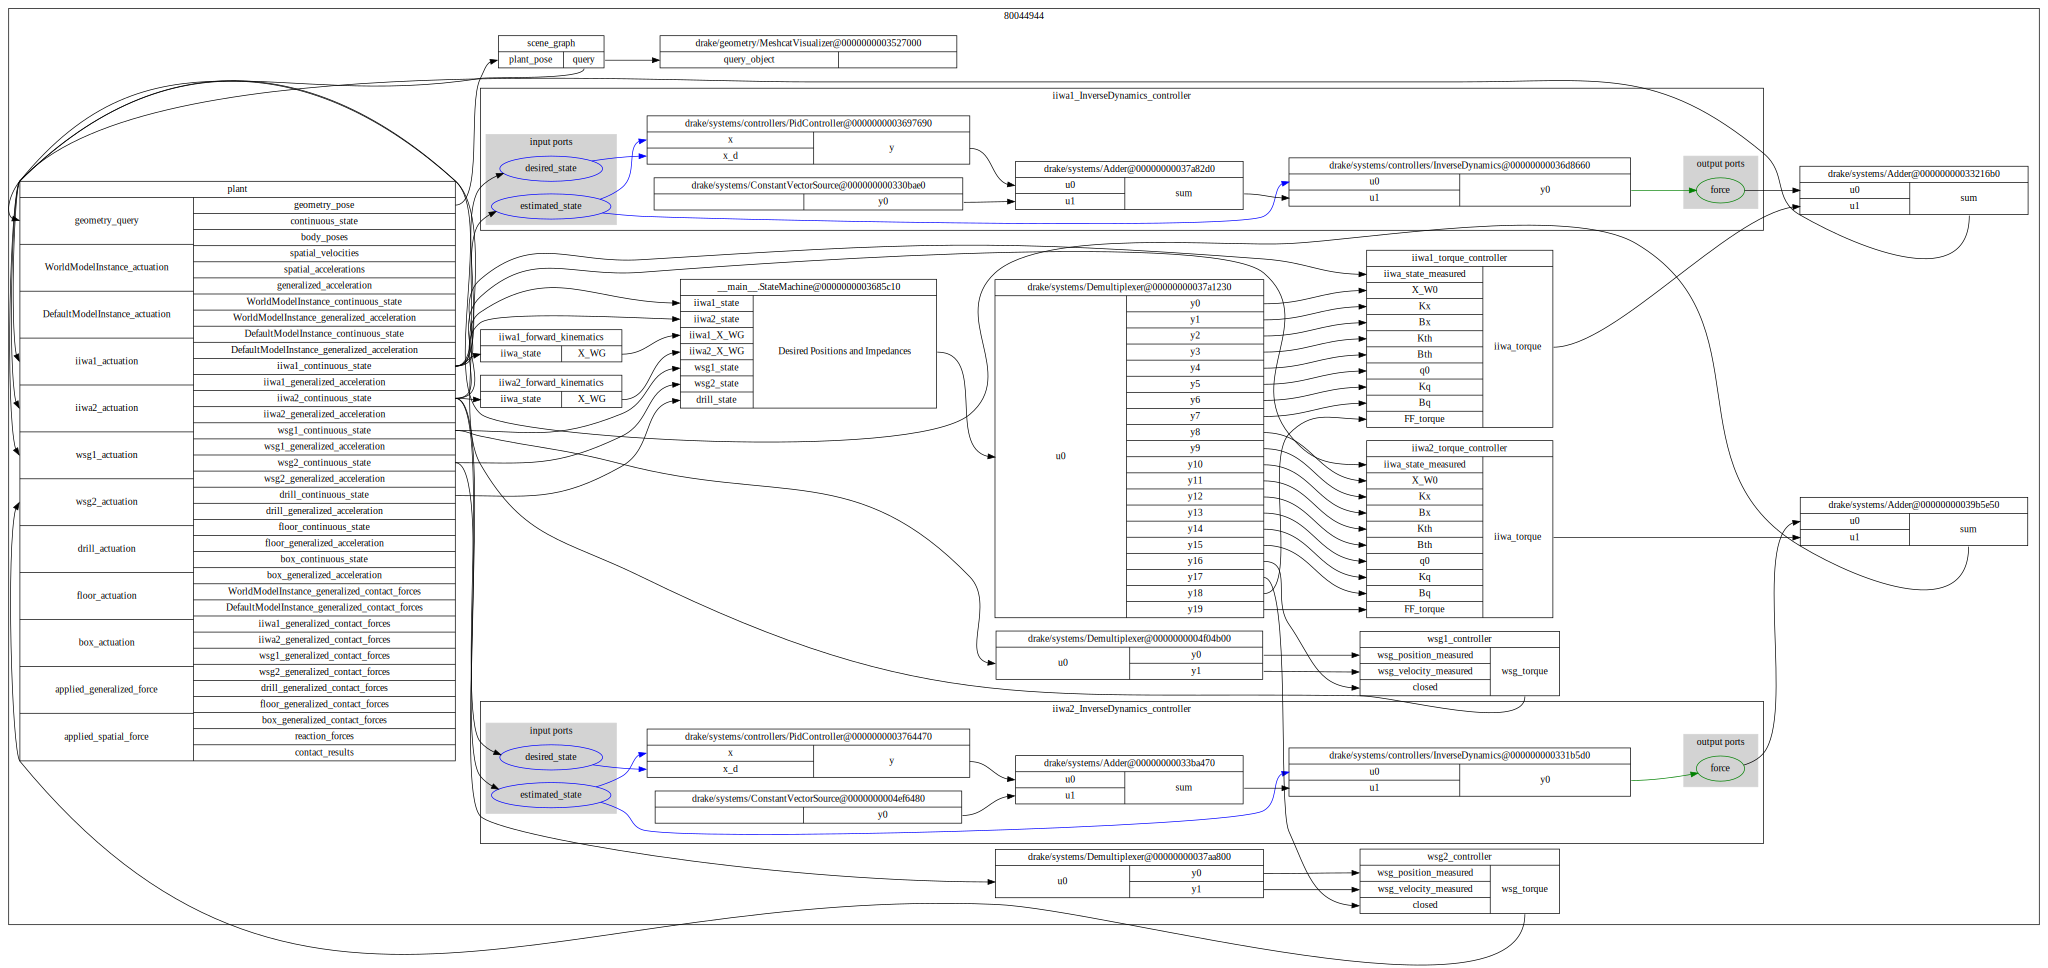

In [ ]:
state_machine = SM(meshcat)
plant,builder,visualizer,instances = MakeManipulationTask(meshcat,state_machine,time_step=0.001)

#TestDrillGeometry(meshcat)

#X = plant.GetFrameByName("trigger_frame")
#X_WT = X.CalcPoseInWorld(context)
#print(X_WT)
#print(plant.GetFrameByName("shaft_frame"))
#print(plant.GetFrameByName("drill_base_frame"))
#shaft_frame
#

diagram = builder.Build()
#iiwa_controller.GetInputPort('desired_state').FixValue(
    #iiwa_controller.GetMyMutableContextFromRoot(context), x0)
# print(context)

SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].create_svg())
#pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].write_png("diagram.png")


In [ ]:
context = diagram.CreateDefaultContext()
plant_context = plant.GetMyMutableContextFromRoot(context)
#print(plant.num_positions())

q_wsg1 = [-0.05,0.05]
q_wsg2 = [-.05,.05]

plant.SetPositions(plant_context,instances[4],state_machine.init_q_drill)
plant.SetPositions(plant_context,instances[0],state_machine.init_q_iiwa1)
plant.SetPositions(plant_context,instances[1],state_machine.init_q_iiwa2)
plant.SetPositions(plant_context,instances[2],q_wsg1)
plant.SetPositions(plant_context,instances[3],q_wsg2)

#X = plant.GetFrameByName("trigger_frame")
#X_WT = X.CalcPoseInWorld(plant_context)
#print(X_WT)

simulator = Simulator(diagram, context)
#simulator.set_target_realtime_rate(0)

visualizer.StartRecording()
simulator.AdvanceTo(38)
visualizer.PublishRecording()
print("Everything compiled!")

# Should we wrap important into a function called BuildAndSimulate() like the example?
# log, plant, plant_context = BuildAndSimulate(compute_ctrl, velocity, duration)

[ 5.25398138e-22 -1.52851095e-16  1.37500000e+00]
Action Complete: 0  Time: 7.0
Action Complete: 1  Time: 16.0
Action Complete: 2  Time: 26.0
Action Complete: 0  Time: 33.0
Everything compiled!


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4920127b-01b3-455c-ad20-cadf5c36e833' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>